### For Google Colab to import Google Drive

In [59]:
# from google.colab import drive
# drive.mount("/content/drive")

In [60]:
# %pip install opencv-python

## Convert JPG to JPEG

In [61]:
import cv2
import os
from pathlib import Path
DATA_DIR = "datasets/unzipped/AI Art vs Real Art/" # Put unzipped files to the unzipped folder and change accordingly

## For Google Colab
# DATA_DIR = "drive/MyDrive/datasets/unzipped/AI Art vs Real Art/" # Put unzipped files to the unzipped folder and change accordingly

def jpg_to_jpeg(data_dir):
    for dir_name in os.listdir(data_dir):
        files = os.path.join(data_dir,dir_name)
        for filepaths in os.listdir(files):
            file_names = os.path.join(files,filepaths)
            if file_names.endswith(".jpg") or file_names.endswith(".JPG"):
                img = cv2.imread(str(file_names))
                cv2.imwrite(file_names[0:-4]+".jpeg", img)
                os.remove(file_names)

In [62]:
import imghdr

IMAGE_EXTENSIONS = [".png", ".jpg", ".jpeg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(DATA_DIR).rglob("*"):
    if filepath.suffix.lower() in IMAGE_EXTENSIONS:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

# Import Tensorflow and Keras

In [63]:
import tensorflow as tf
import keras 

BATCH_SIZE = 64
HEIGHT = 256
WIDTH = 256
IMAGE_SIZE = (HEIGHT, WIDTH)

## StableDiffusion Dataset

In [64]:
train_dataset = keras.preprocessing.image_dataset_from_directory(
    label_mode='binary',
    labels='inferred',
    color_mode='rgb',
    directory=DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=1337,
    validation_split=0.2,
    subset="training",
    verbose=True,
)

val_dataset = keras.preprocessing.image_dataset_from_directory(
    label_mode='binary',
    labels='inferred',
    color_mode='rgb',
    directory=DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=1337,
    validation_split=0.2, # use 20% as validation
    subset="validation",
    verbose=True,

)
# The target labels
class_names = train_dataset.class_names
print(class_names)

Found 913 files belonging to 2 classes.
Using 731 files for training.
Found 913 files belonging to 2 classes.
Using 182 files for validation.
['AI Art', 'Real']


# Display sample images

C:\Users\User\AppData\Local\Temp\ipykernel_11260\956514416.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(class_names[int(labels[i].numpy())])


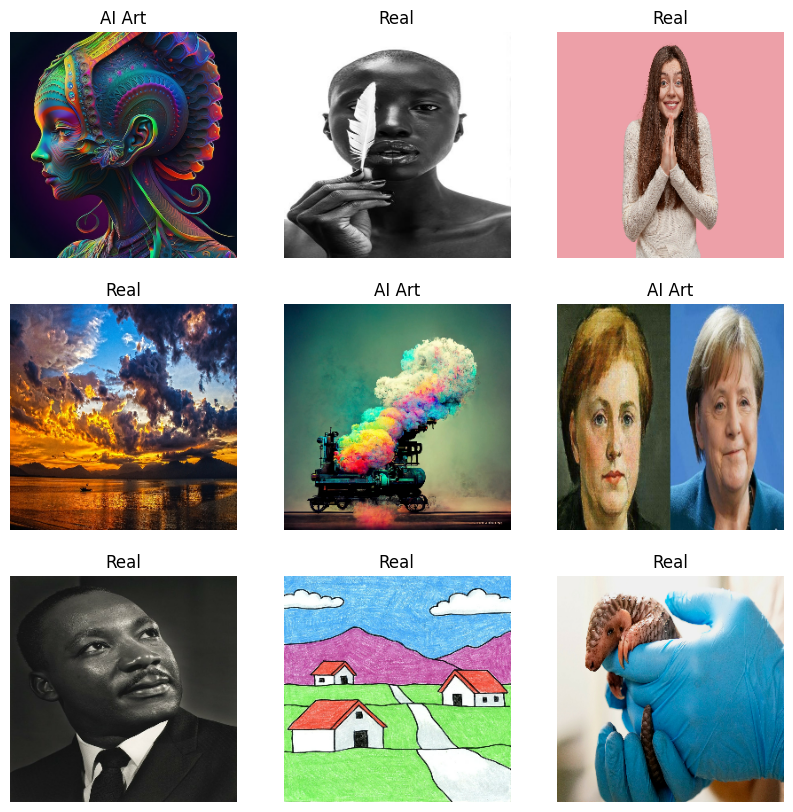

In [65]:
import matplotlib.pyplot as plt

def display_binary_images(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[int(labels[i].numpy())])
            plt.axis("off")

display_binary_images(train_dataset, class_names)

## Model

In [66]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3

# Load the InceptionV3 model pre-trained on ImageNet data
base_model = InceptionV3(input_shape=(HEIGHT, WIDTH, 3), include_top=False, weights='imagenet')

# Freeze the layers in the base model
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Combine the base model with the custom classification head
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# model.summary()

In [67]:
# Example data augmentation setup
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Apply data augmentation to your dataset
augmented_train_data = train_dataset.map(lambda x, y: (data_augmentation(x), y))


In [68]:
NUM_EPOCHS = 10  # Number of epochs for training

In [69]:
# Train the model
history = model.fit(augmented_train_data,
                    epochs=NUM_EPOCHS,
                    validation_data=val_dataset
                    )


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.4940 - loss: 0.9439 - val_accuracy: 0.4945 - val_loss: 9.9004
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - accuracy: 0.6862 - loss: 0.6057 - val_accuracy: 0.5000 - val_loss: 14.4547
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step - accuracy: 0.7550 - loss: 0.5158 - val_accuracy: 0.4890 - val_loss: 25.2684
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.7539 - loss: 0.4771 - val_accuracy: 0.4890 - val_loss: 24.8261
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.7764 - loss: 0.4470 - val_accuracy: 0.4890 - val_loss: 25.7806
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.7819 - loss: 0.4485 - val_accuracy: 0.4890 - val_loss: 39.4573
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.7934 - loss: 0.4367 - val_accuracy: 0.4890 - val_loss: 39.8052
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 0.8407 - loss: 0.3811 - val_accuracy: 0.4890 - val